<a href="https://colab.research.google.com/github/Meena-Mani/batch_size_characterization/blob/master/aerial_cactus_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aerial Cactus Identification

**Tags: MobileNetV2, transfer learning, mini-batch size, aerial image classification**

Date created: Mar 25, 2019   
Last modified: April 25, 2019 


The [Aerial Cactus Identification Challenge ](https://www.kaggle.com/c/aerial-cactus-identification) on Kaggle is a binary classification task to identify columnar cacti in aerial images.

We use a transfer learning framework with a  MobileNetV2  network <a href="#ref1">[1]</a> pretrained on ImageNet to train the classification model. We chose MobileNetV2  because it is a state-of-the art mobile-oriented model and is very effective as a feature extractor for image classifcation, object detection and segmentation. MobileNetV1  introduced depthwise separable convolutions. MobileNetV2, in addition to this, utilizes two new features: (i) linear bottlenecks between the layers, and  (ii) shortcut connections between the bottlenecks. These additions make MobileNetV2 significantly faster and more accurate <a href="#ref2">[2]</a>.

We use this classification setup for  a second task: to characterize the training and validation accuracy for batch sizes in the 16 - 128 regime. For each batch size, we perform three trial runs and the average of these runs is plotted to observe trends. The data is available in [this](https://github.com/Meena-Mani/batch_size_characterization/blob/master/batch_size_characterization.ipynb) colab notebook. Since there is an interplay between learning rate and batch size, we keep the learning rate constant.

## I. Setup for Kaggle Data

In [0]:
!pip install kaggle


In [0]:
!ls -a 

.  ..  .config	sample_data


In [0]:
!mkdir .kaggle

In [0]:
# Get USERNAME and KEY from the kaggle.json file you download
import json
token = {"username":"USERNAME","key":"KEY"}

In [0]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
   json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
# if there is a permissions issue, run next step, then re-run this step
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!kaggle competitions download -c aerial-cactus-identification -p /content

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 43.9MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 51.4MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 69.0MB/s]
 47% 9.00M/19.2M [00:00<00:00, 22.9MB/s]
100% 19.2M/19.2M [00:00<00:00, 43.3MB/s]


In [0]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv  train.zip


In [0]:
!unzip -q  \*.zip


2 archives were successfully processed.


##  II. Imports

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# io related
from skimage.io import imread
from PIL import Image

import os
from glob import glob

%matplotlib inline 

from sklearn.model_selection import train_test_split as tts

In [0]:
TRAIN_IMG_DIR = "/content/train/"
BASE_IMAGE_DIR = '/content'

## III. Data

In [0]:
full_train_ids_df = pd.read_csv(os.path.join(BASE_IMAGE_DIR, 'train.csv'))
full_train_ids_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [0]:
print('Total number of positive class images: {0} ({1:4.2f}%) ' \
      .format(full_train_ids_df['has_cactus'].sum(), \
              full_train_ids_df['has_cactus'].sum() / full_train_ids_df.shape[0]  ))
print('Total number of images:', full_train_ids_df.shape[0])

Total number of positive class images: 13136 (0.75%) 
Total number of images: 17500


#### Display raw images 

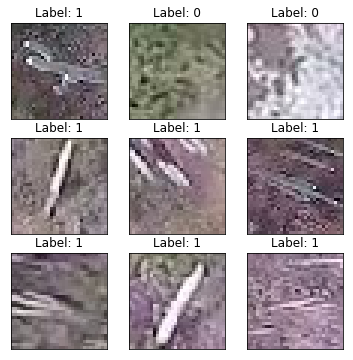

In [0]:
# Plot a random set of images

image_size = []
train_imgs = os.listdir(TRAIN_IMG_DIR)

fig, axes = plt.subplots(3,3, figsize=(6, 6))
axes = axes.ravel()

for idx, img in enumerate(np.random.choice(train_imgs, 9)):
    ax = (axes[idx])
    im = Image.open(TRAIN_IMG_DIR + img)
    image_size.append(im.size)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    lab = full_train_ids_df.loc[full_train_ids_df['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')
 

#### Image Size

In [0]:
print('The image sizes for a random selection of images is:', *image_size, sep='\n')

The image sizes for a random selection of images is:
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


The images are 32 x 32 pixels in size and are not easy to see clearly. This will  not be a problem for a deep learning algorithm.


#### Training and validation data split

In [0]:
# Split the data  into train and validation sets 
# Note: the data generator can do this as well

train_ids, valid_ids = tts(full_train_ids_df['id'], 
                                   test_size = 0.2, 
                                   random_state = 2019,
                                   stratify = full_train_ids_df['has_cactus'])
train_df = full_train_ids_df[full_train_ids_df['id'].isin(train_ids)]
valid_df = full_train_ids_df[full_train_ids_df['id'].isin(valid_ids)]
print('The training set has', train_df.shape[0], 'images.')
print('The validation set has', valid_df.shape[0], 'images.')

The training set has 14000 images.
The validation set has 3500 images.


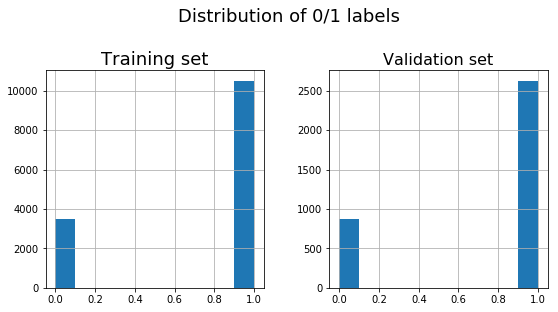

In [0]:
# A plot of the training and validation set histograms 
# to visualize the 0/1 imbalance ratios after stratification

fig=plt.figure(figsize=(9,4))

plt.subplot(1, 2, 1)
ax = plt.gca()
train_df.hist(ax=ax)
plt.title('Training set', fontsize=18)


plt.subplot(1, 2, 2)
ax = plt.gca()
valid_df.hist( ax =ax);
plt.title('Validation set', fontsize=16)

fig.suptitle('Distribution of 0/1 labels', y=1.1, fontsize=18)
plt.show();

## IV. Training

We set up our experiments within a transfer learning classification framework. The training has two stages: feature extraction and fine-tuning.

#### Feature extraction

We start with a base MobileNetV2 model pretrained with ImageNet  and freeze all but the final fully-connected layer.
    The final layer is replaced with a binary classification layer thereby remapping ImageNet classes to the two aerial cactus identification classes. This functions as a fixed feature extractor for the  dataset.
 We train for 10 epochs. We use the RMSprop optimizer and the learning rate is set at $1 \times 10^{-4}$ for each of the mini-batch runs. The weights are used to initialize the fine-tuning stage.

#### Fine-tuning

We unfreeze the last 55 layers of the MobileNetV2 model. We train for another 10 epochs using the RMSprop optimizer and a learning rate of $2 \times 10^{-5}$. The number of iterations varies with the mini-batch size.

#### Experiments

We compare the accuracy and loss profile for the four mini-batch sizes: 16, 32, 64, 128. 


#### Hardware

In [0]:
!nvidia-smi

Tue Apr 23 22:50:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

We are using the NVIDIA Tesla T4 GPU.

#### Install TensorFlow 2.0

In [0]:

!pip install -q tensorflow-gpu==2.0.0-alpha0  # with gpu

    100% |████████████████████████████████| 332.1MB 46kB/s 
    100% |████████████████████████████████| 61kB 26.6MB/s 
    100% |████████████████████████████████| 3.0MB 9.0MB/s 
    100% |████████████████████████████████| 419kB 12.8MB/s 


In [0]:
import tensorflow as tf
from tensorflow import keras
print("The TensorFlow version is ", tf.__version__)
print("The Keras version is ", tf.keras.__version__)

# flow from dataframe -- use the keras_preprocessing.image library
from keras_preprocessing.image import ImageDataGenerator

The TensorFlow version is  2.0.0-alpha0
The Keras version is  2.2.4-tf


### Feature Extraction

#### Globals

In [0]:
image_size = 96
IM_WIDTH, IM_HEIGHT = image_size, image_size
BATCH_SIZE = 64
TL_EPOCHS = 10    # transfer learning epochs
FT_EPOCHS = 10    # fine tuning epochs

#### Base Model

In [0]:
IMG_SHAPE = (IM_WIDTH, IM_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

#### Top Model

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])


In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [0]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
#train_df.has_cactus = train_df.has_cactus.astype(str)
#valid_df.has_cactus = valid_df.has_cactus.astype(str)

train_df = train_df.applymap(str)
valid_df = valid_df.applymap(str)

#### Data Generator 

Using the new `flow_from_dataframe` method because of the directory structure where both classes are present in the same directory.

In [0]:
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory=TRAIN_IMG_DIR, 
                                            x_col="id", 
                                            y_col="has_cactus", 
                                            class_mode="binary",
                                            target_size=(IM_WIDTH, IM_HEIGHT),
                                            batch_size=BATCH_SIZE)

valid_generator=datagen.flow_from_dataframe(dataframe=valid_df, 
                                            directory=TRAIN_IMG_DIR, 
                                            x_col="id", 
                                            y_col="has_cactus", 
                                            class_mode="binary",
                                            shuffle= False,
                                            target_size=(IM_WIDTH, IM_HEIGHT),
                                            batch_size=BATCH_SIZE)

Found 14000 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


In [0]:
steps_per_epoch = train_generator.n // BATCH_SIZE
validation_steps = valid_generator.n // BATCH_SIZE

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=TL_EPOCHS, 
                              workers=4,
                              validation_data=valid_generator, 
                              validation_steps=validation_steps)

Epoch 1/10
218/218 [==============================] - 24s 109ms/step - loss: 0.4616 - accuracy: 0.7800 - val_loss: 1.0162 - val_accuracy: 0.3819
Epoch 2/10
218/218 [==============================] - 16s 73ms/step - loss: 0.2148 - accuracy: 0.9170 - val_loss: 0.9207 - val_accuracy: 0.5292
Epoch 3/10
218/218 [==============================] - 19s 88ms/step - loss: 0.1557 - accuracy: 0.9412 - val_loss: 0.8676 - val_accuracy: 0.6068
Epoch 4/10
218/218 [==============================] - 16s 73ms/step - loss: 0.1323 - accuracy: 0.9501 - val_loss: 0.7837 - val_accuracy: 0.6644
Epoch 5/10
218/218 [==============================] - 16s 74ms/step - loss: 0.1131 - accuracy: 0.9585 - val_loss: 0.7138 - val_accuracy: 0.6982
Epoch 6/10
218/218 [==============================] - 17s 78ms/step - loss: 0.1017 - accuracy: 0.9609 - val_loss: 0.6522 - val_accuracy: 0.7350
Epoch 7/10
218/218 [==============================] - 16s 74ms/step - loss: 0.0969 - accuracy: 0.9642 - val_loss: 0.5589 - val_accuracy

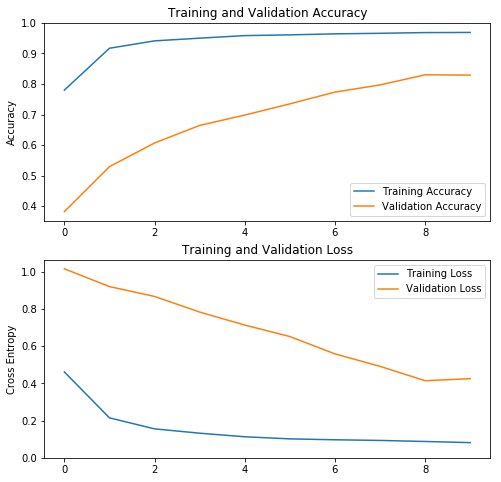

In [0]:
# plot training and validation performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()


### Fine Tuning

In [0]:
base_model.trainable = True

In [0]:
# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


#### Image Augmentation/Data Generator

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=15,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=[0.9, 1.25],
                                 horizontal_flip=True,
                                 vertical_flip=False,
                                 fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)



train_generator=train_datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory=TRAIN_IMG_DIR, 
                                            x_col="id", 
                                            y_col="has_cactus", 
                                            class_mode="binary",
                                            target_size=(IM_WIDTH, IM_HEIGHT),
                                            batch_size=BATCH_SIZE)

valid_generator=test_datagen.flow_from_dataframe(dataframe=valid_df, 
                                            directory=TRAIN_IMG_DIR, 
                                            x_col="id", 
                                            y_col="has_cactus", 
                                            class_mode="binary",
                                            shuffle= False,
                                            target_size=(IM_WIDTH, IM_HEIGHT),
                                            batch_size=BATCH_SIZE)

Found 14000 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


In [0]:
history_FT = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=FT_EPOCHS, 
                                   workers=4,
                                   validation_data=valid_generator, 
                                   validation_steps=validation_steps)

Epoch 1/10
218/218 [==============================] - 50s 231ms/step - loss: 0.0911 - accuracy: 0.9651 - val_loss: 0.4202 - val_accuracy: 0.8600
Epoch 2/10
218/218 [==============================] - 38s 175ms/step - loss: 0.0571 - accuracy: 0.9797 - val_loss: 0.5783 - val_accuracy: 0.8275
Epoch 3/10
218/218 [==============================] - 38s 175ms/step - loss: 0.0513 - accuracy: 0.9808 - val_loss: 0.5072 - val_accuracy: 0.8614
Epoch 4/10
218/218 [==============================] - 39s 178ms/step - loss: 0.0425 - accuracy: 0.9842 - val_loss: 0.5507 - val_accuracy: 0.8536
Epoch 5/10
218/218 [==============================] - 37s 171ms/step - loss: 0.0387 - accuracy: 0.9859 - val_loss: 0.3881 - val_accuracy: 0.8895
Epoch 6/10
218/218 [==============================] - 38s 175ms/step - loss: 0.0333 - accuracy: 0.9880 - val_loss: 0.3915 - val_accuracy: 0.8941
Epoch 7/10
218/218 [==============================] - 39s 178ms/step - loss: 0.0313 - accuracy: 0.9878 - val_loss: 0.3993 - val_ac

In [0]:
acc += history_FT.history['accuracy']
val_acc += history_FT.history['val_accuracy']

loss += history_FT.history['loss']
val_loss += history_FT.history['val_loss']

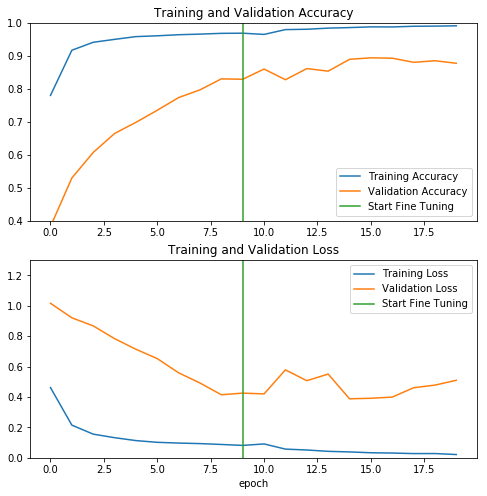

In [0]:
#TL_EPOCHS = 10

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([TL_EPOCHS-1, TL_EPOCHS-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([TL_EPOCHS-1, TL_EPOCHS-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We  see the generalization gap when the batch size is 64. Similar plots are generated for batch sizes 16, 32 and 128.

## V. References and Further Reading

<a name="ref1"></a>[1] [Sandler, M., et al. "Inverted Residuals and Linear Bottlenecks: Mobile Networks for Classification, Detection and Segmentation." arXiv preprint arXiv:1801.04381 (2018).](http://arxiv.org/abs/1801.04381)

<a name="ref2"></a>[2] [Sandler, M. , Howard, A. "MobileNetV2: The Next Generation of On-Device Computer Vision Networks " Google AI Blog (blog). April 3, 2018](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html)

**Author:  Meena Mani  
Email:   meenas.mailbag@gmail.com   
Twitter: @meena_uvaca  **  